In [41]:
%pip install haystack-ai gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 51.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.7/318.7 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.0/94.0 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 67.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.4/71.4 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 10.2 MB/s eta 0:00:00
  Attempting uninstall: tomlkit
    Found existing installation: tomlkit 0.13.2
    Uninstalling tomlkit-0.13.2:
      Successfully uninstalled tomlkit-0.13.2


In [24]:
import os
from haystack.utils import Secret
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack.components.retrievers.in_memory import InMemoryBM25Retriever
from haystack.components.builders.answer_builder import AnswerBuilder
from haystack.components.builders.prompt_builder import PromptBuilder
from haystack import component, Pipeline, Document
from haystack.components.builders import PromptBuilder
from haystack.components.generators import OpenAIGenerator
from haystack.components.generators.chat.openai import OpenAIChatGenerator
from haystack.dataclasses import ChatMessage
from haystack.components.joiners import BranchJoiner
from haystack_experimental.components.tools import OpenAIFunctionCaller
from google.colab import userdata

In [5]:
# Write documents to InMemoryDocumentStore
document_store = InMemoryDocumentStore()
document_store.write_documents([
    Document(content="My name is Jean and I live in Paris."),
    Document(content="My name is Mark and I live in Berlin."),
    Document(content="My name is Giorgio and I live in Rome.")
])

# Build a RAG pipeline
prompt_template = """
Given these documents, answer the question.
Documents:
{% for doc in documents %}
    {{ doc.content }}
{% endfor %}
Question: {{question}}
Answer:
"""

retriever = InMemoryBM25Retriever(document_store=document_store)
prompt_builder = PromptBuilder(template=prompt_template)
api_key = userdata.get('OPEN_AI_API_KEY')
llm = OpenAIGenerator(api_key=Secret.from_token(api_key))

rag_pipeline = Pipeline()
rag_pipeline.add_component("retriever", retriever)
rag_pipeline.add_component("prompt_builder", prompt_builder)
rag_pipeline.add_component("llm", llm)
rag_pipeline.connect("retriever", "prompt_builder.documents")
rag_pipeline.connect("prompt_builder", "llm")

# Ask a question
question = "Who lives in Paris?"
results = rag_pipeline.run(
    {
        "retriever": {"query": question},
        "prompt_builder": {"question": question},
    }
)

print(results["llm"]["replies"])

['Jean lives in Paris.']


In [6]:
WEATHER_INFO = {
    "Berlin": {"weather": "mostly sunny", "temperature": 7, "unit": "celsius"},
    "Paris": {"weather": "mostly cloudy", "temperature": 8, "unit": "celsius"},
    "Rome": {"weather": "sunny", "temperature": 14, "unit": "celsius"},
    "Madrid": {"weather": "sunny", "temperature": 10, "unit": "celsius"},
    "London": {"weather": "cloudy", "temperature": 9, "unit": "celsius"},
}

def get_current_weather(location: str):
    if location in WEATHER_INFO:
        return WEATHER_INFO[location]
    else:
        return {"weather": "sunny", "temperature": 70, "unit": "fahrenheit"}

In [7]:
tools = [
    {
        "type": "function",
        "function": {
            "name": "rag_pipeline_func",
            "description": "Get information about where people live",
            "parameters": {
                "type": "object",
                "properties": {
                    "query": {
                        "type": "string",
                        "description": "The query to use in the search. Infer this from the user's message. It should be a question or a statement",
                    }
                },
                "required": ["query"],
            },
        },
    },
    {
        "type": "function",
        "function": {
            "name": "get_current_weather",
            "description": "Get the current weather",
            "parameters": {
                "type": "object",
                "properties": {
                    "location": {"type": "string", "description": "The city"}
                },
                "required": ["location"],
            },
        },
    },
]

In [26]:
chat_generator = OpenAIChatGenerator(api_key=Secret.from_token(api_key), model="gpt-3.5-turbo", generation_kwargs={'tools': tools})
replies = chat_generator.run(messages=[ChatMessage.from_user("Where does Mark live?")])
print(replies['replies'][0])

ChatMessage(content='[{"id": "call_NvODz3HmLafYjYSBNOa28YIb", "function": {"arguments": "{\\"query\\":\\"Where does Mark live?\\"}", "name": "rag_pipeline_func"}, "type": "function"}]', role=<ChatRole.ASSISTANT: 'assistant'>, name=None, meta={'model': 'gpt-3.5-turbo-0125', 'index': 0, 'finish_reason': 'tool_calls', 'usage': {'completion_tokens': 20, 'prompt_tokens': 104, 'total_tokens': 124, 'completion_tokens_details': CompletionTokensDetails(reasoning_tokens=0)}})


In [30]:
import pprint
function_caller = OpenAIFunctionCaller(available_functions={"rag_pipeline_func": rag_pipeline,
                                                            "get_current_weather": get_current_weather})

results = function_caller.run(messages=replies['replies'])
pprint.pprint(results["function_replies"])


[ChatMessage(content='[{"id": "call_NvODz3HmLafYjYSBNOa28YIb", "function": '
                     '{"arguments": "{\\"query\\":\\"Where does Mark '
                     'live?\\"}", "name": "rag_pipeline_func"}, "type": '
                     '"function"}]',
             role=<ChatRole.ASSISTANT: 'assistant'>,
             name=None,
             meta={'finish_reason': 'tool_calls',
                   'index': 0,
                   'model': 'gpt-3.5-turbo-0125',
                   'usage': {'completion_tokens': 20,
                             'completion_tokens_details': CompletionTokensDetails(reasoning_tokens=0),
                             'prompt_tokens': 104,
                             'total_tokens': 124}}),
 ChatMessage(content='Seems there was an error while running the function: '
                     "'Pipeline' object is not callable",
             role=<ChatRole.ASSISTANT: 'assistant'>,
             name=None,
             meta={}),
 ChatMessage(content='Seems there was

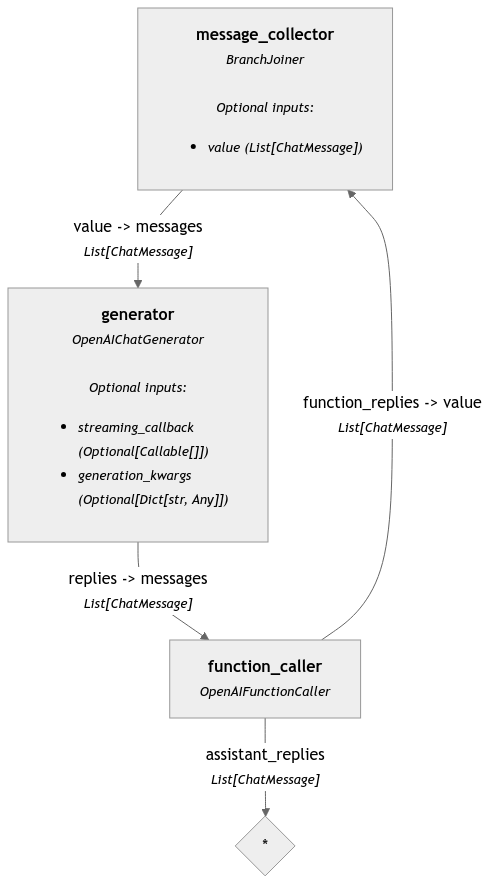

In [36]:
from typing import List
from haystack.components.joiners import BranchJoiner
from haystack_experimental.components.tools import OpenAIFunctionCaller
message_collector = BranchJoiner(List[ChatMessage])
chat_generator = OpenAIChatGenerator(api_key=Secret.from_token(api_key),model="gpt-3.5-turbo", generation_kwargs={'tools': tools})
function_caller = OpenAIFunctionCaller(available_functions={"rag_pipeline_func": rag_pipeline,
                                                            "get_current_weather": get_current_weather})

chat_agent = Pipeline()
chat_agent.add_component("message_collector", message_collector)
chat_agent.add_component("generator", chat_generator)
chat_agent.add_component("function_caller", function_caller)

chat_agent.connect("message_collector", "generator.messages")
chat_agent.connect("generator", "function_caller")
chat_agent.connect("function_caller.function_replies", "message_collector")

chat_agent.show()


In [45]:
messages = [
    ChatMessage.from_system(
        """If needed, break down the user's question into simpler questions and follow-up questions that you can use with your tools.
        Don't make assumptions about what values to plug into functions. Ask for clarification if a user request is ambiguous."""
    )
]
while True:
    user_input = input("INFO: Type 'exit' or 'quit' to stop\n")
    if user_input.lower() == "exit" or user_input.lower() == "quit":
        break
    messages.append(ChatMessage.from_user(user_input))
    response = chat_agent.run({"message_collector": {"value": messages}})
    messages.extend(response['function_caller']['assistant_replies'])
    print(response['function_caller']['assistant_replies'][0].content)

INFO: Type 'exit' or 'quit' to stop
where does Mark live ?
Mark lives in Paris. The current weather in Paris is mostly cloudy with a temperature of 8°C.
INFO: Type 'exit' or 'quit' to stop
quit


In [46]:
def chat(message, history):
    messages.append(ChatMessage.from_user(message))
    response = chat_agent.run({"message_collector": {"value": messages}})
    messages.extend(response['function_caller']['assistant_replies'])
    return response['function_caller']['assistant_replies'][0].content

In [44]:
import gradio as gr
demo = gr.ChatInterface(
    fn=chat,
    examples=[
        "Can you tell me where Giorgio lives?",
        "What's the weather like in Madrid?",
        "Who lives in London?",
        "What's the weather like where Mark lives?",
    ],
    title="Ask me about weather or where people live!",
)
demo.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://e7e888c237c1b016b1.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
